### Install and Import Dependencie

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
import matplotlib.pyplot as plt

# imageio converts a numpy array into a GIf
import imageio

### 1. Build Data Loading Functions

In [2]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        # Getting the static lip region (Isolating the mouth region)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    # Standadizing 
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    # Casting it into a float32 
    return tf.cast((frames - mean), tf.float32) / std

In [3]:
# List of all the letters we might encounter
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [4]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


2023-02-15 10:35:46.314976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Alignments

In [5]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

### Load Data

In [6]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [7]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [8]:
tf.convert_to_tensor(test_path).numpy().decode('UTF-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [9]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

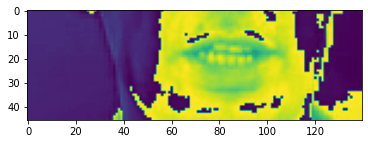

In [10]:
plt.imshow(frames[40])

In [11]:
tf.strings.reduce_join([bytes.decode(x.numpy()) for x in num_to_char(alignments.numpy())])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

tf.py_function -> 
**Wraps a python function into a TensorFlow op that executes it eagerly.**

tf.py_function(
    func, inp, Tout, name=None
)
* If you wanna use pure string processing, wrap it inside a tf.py_function


In [12]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [13]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

### 2. Create Data Pipeline 

In [14]:
import matplotlib.pyplot as plt

In [15]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)

# We are padding into group sizes of 2(2 videos and 2 alignments), 75 frames and 40 tokens for each one of our alignments
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))

# We preload our model as it is training
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [16]:
frames, alignments = data.as_numpy_iterator().next()

In [17]:
len(frames)

2

In [18]:
test = data.as_numpy_iterator()

In [19]:
val = test.next(); val[0]

array([[[[[1.5574893 ],
          [1.4850478 ],
          [1.4850478 ],
          ...,
          [0.3622068 ],
          [0.25354475],
          [0.25354475]],

         [[1.4850478 ],
          [1.3039445 ],
          [1.4126065 ],
          ...,
          [0.3622068 ],
          [0.25354475],
          [0.25354475]],

         [[1.4850478 ],
          [1.4850478 ],
          [1.5212686 ],
          ...,
          [0.3622068 ],
          [0.3984275 ],
          [0.3984275 ]],

         ...,

         [[1.0866205 ],
          [1.0866205 ],
          [1.0866205 ],
          ...,
          [0.10866204],
          [0.10866204],
          [0.10866204]],

         [[1.0503997 ],
          [1.0503997 ],
          [1.0503997 ],
          ...,
          [0.10866204],
          [0.10866204],
          [0.10866204]],

         [[1.0503997 ],
          [1.0503997 ],
          [1.0503997 ],
          ...,
          [0.10866204],
          [0.10866204],
          [0.07244136]]],


        [[[1.4126

In [20]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.236273765563965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.236273765563965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.236273765563965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.236273765563965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.236273765563965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.236273765563965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.236273765563965]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

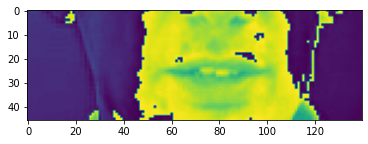

In [21]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [22]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue with b four please'>

### 3. Design a Deep Neural Network

In [23]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [24]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [25]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# It allows us to have 75 inputs 
model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [27]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [28]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'3llllllllllvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvllllllllllllllllllllvvvvvvvvvvv'>

In [29]:
model.input_shape

(None, 75, 46, 140, 1)

In [30]:
model.output_shape

(None, 75, 41)

### 4. Setup Training Options and Train

In [31]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

* Taken from Automatic CTC Loss 
<a href= 'https://keras.io/examples/audio/ctc_asr/'>Automatic CTC Loss</a>

In [32]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [33]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [34]:
model.compile(optimizer = Adam(learning_rate = 0.0001) , loss = CTCLoss)

In [35]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'), monitor = 'loss', save_weights_only = True)

In [36]:
schedule_callback = LearningRateScheduler(scheduler)

In [37]:
example_callback = ProduceExample(test)

AttributeError: '_NumpyIterator' object has no attribute 'as_numpy_iterator'

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

NameError: name 'example_callback' is not defined

### 5. Make a prediction

In [38]:
model.load_weights('models - checkpoint 96/checkpoint')

In [51]:
sample = test.next()

In [52]:
yhat = model.predict(sample[0])

1/1 [==============================] - 4s 4s/step


In [53]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by f six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue with y six now'>]

In [54]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length = [75 , 75], greedy = True)[0][0].numpy()

In [56]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by f six now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue with y six now'>]

### Test on a Video

In [57]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [59]:
print('-'*100, "Real Text")
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

---------------------------------------------------------------------------------------------------- Real Text


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [60]:
yhat = model.predict(tf.expand_dims(sample[0], axis = 0))

1/1 [==============================] - 2s 2s/step


In [62]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [63]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]